In [54]:
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import numpy as np

In [55]:


def manakovSSF(Ex, Ey, hz, Lspan, Ltotal, alpha, gamma, D, Fc, Fs):
    
    c = 299792458   # speed of light (vacuum)
    c_kms = c/1e3
    λ = c/Fc
    α  = alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c_kms)
    γ = gamma
    
    l = len(Ex)
    
    Nfft = l;

    ω = 2*np.pi*Fs*fftfreq(Nfft)
    
    Nspans = int(np.floor(Ltotal/Lspan))
    Nsteps = int(np.floor(Lspan/hz))

    Ex = fft(Ex) #Pol. X 
    Ey = fft(Ey) #Pol. Y 
    
    for spanN in range(1, Nspans+1):
        for stepN in range(1, Nsteps+1):
            
            # First linear step:
            Ex = Ex*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
            Ey = Ey*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))

            # Nonlinear step
            Ex = ifft(Ex);
            Ey = ifft(Ey);
            
            Ex = Ex*np.exp(1j*γ*8/9*(np.abs(Ex)**2 + np.abs(Ey)**2)*(hz))
            Ey = Ey*np.exp(1j*γ*8/9*(np.abs(Ex)**2 + np.abs(Ey)**2)*(hz))
   
            # Second linear step
            Ex = fft(Ex);
            Ey = fft(Ey);
            Ex = Ex*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
            Ey = Ey*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
        
        Ex = Ex*np.exp(α*Nsteps*hz)
        Ey = Ey*np.exp(α*Nsteps*hz)
    
    Ex = ifft(Ex)
    Ey = ifft(Ey)
    
    return Ex, Ey
    

In [56]:
Ltotal = 100
Lspan  = 10
hz = 0.1
alpha = 0.2
gamma = 1.3
D = 16
Fc = 193.1e12
Fs = 64e9
P0 = 1e-3

In [57]:
from scipy import signal
import matplotlib.pyplot as plt
t       = np.linspace(-4, 4, 128, endpoint=False)
i, q, e = signal.gausspulse(t, fc=5, retquad=True, retenv=True)

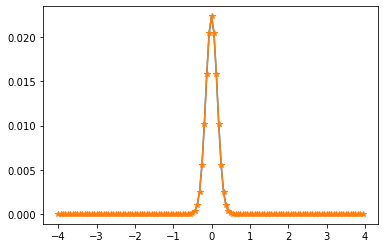

In [58]:
Ex = np.sqrt(P0/2)*e
Ey = np.sqrt(P0/2)*e

plt.plot(t, np.abs(Ex), t, np.abs(Ey),'*-')

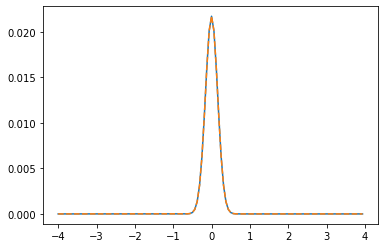

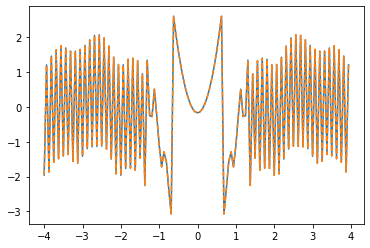

In [59]:
Ex_out, Ey_out = manakovSSF(Ex, Ey, hz, Lspan, Ltotal, alpha, gamma, D, Fc, Fs)

plt.plot(t, np.abs(Ex_out), t, np.abs(Ey_out),'--')
plt.figure()
plt.plot(t, np.angle(Ex_out), t, np.angle(Ey_out),'--')

In [60]:
from commpy.modulation import Modem, QAMModem
from commpy.utilities  import signal_power, upsample
from commpy.filters    import rrcosfilter
from scipy.signal import lfilter

In [61]:
def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]

In [62]:
# simulation parameters

M   = 16  # Modulation order
SpS = 8

Rs     = 32e9
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
alpha  = 0.05          # Rolloff do filtro RRC
N      = 4*1024          # Número de coeficientes do filtro RRC
EbN0dB = 20
   
# generate random bits
np.random.seed(33)
bits_x   = np.random.randint(2, size=3*2**12)    
np.random.seed(23)
bits_y   = np.random.randint(2, size=3*2**12)    

# map bits to constellation symbols
mod = QAMModem(m=M)
symb_x = mod.modulate(bits_x)
symb_y = mod.modulate(bits_y)

Es = mod.Es;

# normalize symbols energy to 1
symb_x = symb_x/np.sqrt(Es)
symb_y = symb_y/np.sqrt(Es)

# upsampling
symbolsUp_x = upsample(symb_x, SpS)
symbolsUp_y = upsample(symb_y, SpS)

# pulse shaping
tindex, rrcFilter = rrcosfilter(N, alpha, Ts, Fa)
sig_x  = filterNoDelay(rrcFilter, symbolsUp_x)     
sig_y  = filterNoDelay(rrcFilter, symbolsUp_y)

sig_x  = np.sqrt(P0/2)*sig_x/np.sqrt(signal_power(sig_x))
sig_y  = np.sqrt(P0/2)*sig_y/np.sqrt(signal_power(sig_y))


sig_x_out, sig_y_out = manakovSSF(sig_x, sig_y, hz, Lspan, Ltotal, alpha, gamma, D, Fc, Fa)

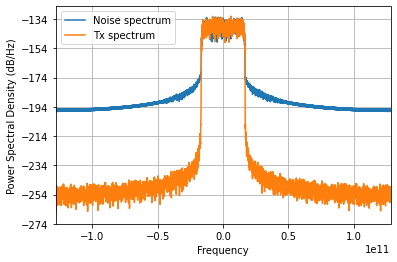

In [63]:
# plot spectrums
plt.figure(2);
plt.psd(sig_x_out,Fs=Fa, NFFT = 8*1024, label = 'Noise spectrum')
plt.psd(sig_x,Fs=Fa, NFFT = 8*1024, label = 'Tx spectrum')
plt.legend(loc='upper left');
plt.xlim(-Fa/2,Fa/2);